# Developing a Framework to Interpret Werarble Sensor-based Activity Recognition learned from Semi-Supervised Deep Networks

### To-Do:
#### SSL Model
- [x] understand poor performance in AoT task on example data

#### Attribution Function(s)
- [x] method agnostic attribution function
- [x] fine-tune LRP scripts (DCNN)
- [x] fine-tune LRP scripts (SSL)
- [x] lrp panel plots
- [x] create pytorch dataloader for example data
- [ ] create pytorch dataloader for UKB stored data(@Hang, I assume you you have one?)
- [x] generate average epochs for each class using DTW dynamic barycenter averaging (DBA)
- [x] generate reversed samples and index "exemplary" samples
- [ ] GAN to create synthetic epochs for each class


#### Plotting Attribution
- [x] generate paramateriseable lrp plotting functions
- [x] Apply lrp directly onto the signals
- [x] shorten lrp colorbar
- [x] check lrp timestamps match the signal
- [x] add cwt colorbar axis to the right of the plot
- [ ] move plotting functions to attribution.py

#### Experiment(s)
- [x] compare activity LRP interpretations to RF features
- [x] fine-tune LRP for SSL AoT
- [ ] fine-tune LRP for SSL HAR
- [ ] Evaluate LRP for AoT tasks
- [ ] Evaluate LRP for AoT HAR / contextual experiments 
- [x] compare relevance between different models
- [x] evaluate attribution on average epochs (end-to-end CNN)
- [ ] evaluate attribution on average epochs (SSL CNN)
- [x] (DCNN) compare (empirically) between different attribution methods uisng permutation tests
- [x] (SSL) compare (empirically) between different attribution methods uisng permutation tests
- [ ] compare GAN to DTW DBA
- [ ] cLRP: compare attribution to video images

In [1]:
import os
from os.path import expanduser
home = expanduser("~")

import numpy as np
import pickle

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf

import hydra

#PyTorch
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

import pathlib
from torchsummary import summary
import sslearning 

import captum
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from captum.attr._utils.attribution import GradientAttribution, LayerAttribution
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule

from sslearning.models.accNet import SSLNET, Resnet
from sslearning.utils import load_weights_dist2norm, trans30two1
from downstream_task_evaluation import load_weights
from sslearning.data.data_loader import subject_dataset

import gc
cuda = torch.cuda.is_available()
gc.collect()
torch.cuda.empty_cache()
cudnn.benchmark = True

def set_seed():
    # For reproducibility
    random_seed = 42
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    cudnn.benchmark = True
    if cuda:
        torch.cuda.manual_seed_all(random_seed)
  
set_seed()
device = torch.device("cpu")



In [2]:
from IPython.display import set_matplotlib_formats
get_ipython().run_line_magic('matplotlib', 'inline')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
set_matplotlib_formats('png')
# http://pandas-docs.github.io/pandas-docs-travis/whatsnew/v0.21.1.html#restore-matplotlib-datetime-converter-registration

from pathlib import Path 

SAVE_PATH=home + '/results/ssl/viz/'

#Python ≥ 3.5, see: https://stackoverflow.com/questions/273192/how-can-i-safely-create-a-nested-directory
Path(SAVE_PATH).mkdir(parents=True, exist_ok=True) 


# Network Initilisation

In [3]:
config_dir = pathlib.Path('conf/')
hydra.initialize(config_path=config_dir)
cfg=compose(config_name="config.yaml")
cfg=compose(overrides= ["+model=resnet", "+dataloader=default", "+task=time_reversal", "++task.positive_ratio=0.5"])
cfg.dataloader.epoch_len=10

/home/scro3203/anaconda3/envs/ssl/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/home/scro3203/anaconda3/envs/ssl/lib/python3.9/site-packages/hydra/core/default_element.py:122: UserWarning: In 'dataloader/default': Usage of deprecated keyword in package header '# @package _group_'.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/changes_to_package_header for more information
  deprecation_warning(
/home/scro3203/anaconda3/envs/ssl/lib/python3.9/site-packages/hydra/core/default_element.py:122: UserWarning: In 'augmentation/no_aug': Usage of deprecated keyword in package header '# @package _group_'.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/changes_to_package_header for more information
  deprecation_warning(
/home/scro3203/anaconda3/envs/ssl/lib/python3.9/site-packa

In [4]:
print(cfg)

{'model': {'learning_rate': 0.0001, 'name': 'mtl_baseline_rotation${task.rotation}_time${task.time_reversal}_data${data.data_name}_lr${model.learning_rate}_resnet_v${model.resnet_version}_win_size${dataloader.epoch_len}_posR_${task.positive_ratio}', 'mixed_precision': False, 'resnet_version': 1, 'warm_up_step': 5, 'lr_scale': False}, 'dataloader': {'num_sample_per_subject': 500, 'sample_rate': 30, 'epoch_len': 10}, 'task': {'rotation': False, 'switch_axis': False, 'time_reversal': True, 'positive_ratio': 0.5}}


In [5]:
# Uncomment this for Andrew
model_name='final_model_10.mdl'
model_path = home + '/data/ssl/' + model_name
#model_path = '/data/UKBB/final_models/100k_epoch_30.mdl'

model = Resnet(output_size=2, cfg=cfg)
load_weights_dist2norm(model, model_path)
model.eval()

Resnet(
  (feature_extractor): Sequential(
    (layer1): Sequential(
      (0): Conv1d(3, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
      (1): ResBlock(
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
        (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
        (relu): ReLU(inplace=True)
      )
      (2): ResBlock(
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
        (conv2): Conv1d(6

## Helper dataset

In [6]:
print(cfg)

{'model': {'learning_rate': 0.0001, 'name': 'mtl_baseline_rotation${task.rotation}_time${task.time_reversal}_data${data.data_name}_lr${model.learning_rate}_resnet_v${model.resnet_version}_win_size${dataloader.epoch_len}_posR_${task.positive_ratio}', 'mixed_precision': False, 'resnet_version': 1, 'warm_up_step': 5, 'lr_scale': False}, 'dataloader': {'num_sample_per_subject': 500, 'sample_rate': 30, 'epoch_len': 10}, 'task': {'rotation': False, 'switch_axis': False, 'time_reversal': True, 'positive_ratio': 0.5}}


# LRP Example

In [7]:
from sslearning.data.datautils import Transform


#labels=['forward', 'reversed']
#data = np.load(sample_path)
#bs, nchannel, _=data.shape

#X_data_forward = data[:, :, :300]
#Y_forward=np.zeros(X_data_forward.shape[0]).astype(int)

### @Hang: 
- do these inputs need to be further normalised between [-1,1] for input to your model?

Don't think normalisation was used 

- what is the transformation you use?


In [8]:
'''generate reversed data'''
from sslearning.data.data_transformation import flip
#X_data_reverse = [flip(x, 1) for x in X_data_forward]
#X_data_reverse=np.asarray(X_data_reverse)
#Y_reverse=np.ones(X_data_reverse.shape[0]).astype(int)

In [9]:
'''Merge sample data'''
#X_data=np.vstack((X_data_forward,X_data_reverse))
#Y=np.hstack((Y_forward,Y_reverse))

'Merge sample data'

In [10]:
#X_data=torch.tensor(X_data, requires_grad=True)
#softmax = nn.Softmax(dim=1)
## Q: do we need requires grad?
#X_data=X_data.to(device, dtype=torch.float)

In [11]:
#from sslearning.utils import onehot

#Normalise the data between [-1,1]...
transform=Transform(transformations=['rescale'], channel_wise=False, limits=[-1, 1])
#or...: X_data=[transform(x) for x in X_data]

#dataset = Dataset(X_data, Y, transformation=transform, target_transformation=onehot(len(labels)))
#data_generator=DataLoader(dataset, batch_size=64, shuffle=False) 

In [12]:
from interpretability.attribution import forward_by_batches

# Uncomment this for Andrew
sample_path = home + '/data/ssl/sample_subject.npy'
#sample_path = '/data/UKBB/SSL/mini_sample/5300274_90001_0_0.npy'

labels=['forward', 'reversed']

dataset = subject_dataset(sample_path, cfg)
data_generator=DataLoader(dataset, batch_size=64, shuffle=False) 

In [13]:
'''evaluate the model'''
## Option 1: Overall
'''
#Input shape should be: [batchSize x channels x time samples]
X_data=torch.tensor(X_data, requires_grad=True)
softmax = nn.Softmax(dim=1)
## Q: do we need requires grad?
X_data=X_data.to(device, dtype=torch.float)
logits=model(X_data)
prob = softmax(logits).cpu().detach().numpy()
Yfit=np.argmax(prob, axis=1).astype(int)
#return to numpy
X_data=X_data.cpu().detach().numpy()
'''

## Option 2: iterate over batches
Y, Yfit, _, prob=forward_by_batches(model, data_generator, device=device)


In [14]:
import sklearn.metrics as metrics
from sslearning.utils import compute_scores, print_scores, get_one_hot

print_scores(compute_scores(Y, Yfit))
#auroc=metrics.roc_auc_score(get_one_hot(Y,  prob.shape[1]), prob, average='macro', multi_class='ovr')

#print('AUROC', auroc)

Accuracy score: 0.979
Balanced accuracy score: 0.9790000000000001
Cohen kappa score: 0.958

Per-class recall scores:
sleep      : 0.9906666666666667
awake   : 0.9673333333333334

Confusion matrix:
 [[1486   14]
 [  49 1451]]


In [15]:
'''determine exemplary samples'''
#1. predicted correctly for forward and reversed samples
#2. high posterior probabilty for each prediction (>threshold)

X_data=dataset.X.cpu().detach().numpy()

threshold=0.85

all_mask=(Y==Yfit) & (np.max(prob, axis=1)>threshold)
print('Total # exemplary examples: {:} ({:.2f}%)'.format(all_mask.sum(), 100*all_mask.sum()/len(all_mask)))

fwd_idx=np.arange(0, len(X_data), 2)
rev_idx=np.arange(1, len(X_data), 2)

X_fwd=X_data[fwd_idx]
X_rev=X_data[rev_idx]

fwd_mask=(Y[fwd_idx]==Yfit[fwd_idx]) & (np.max(prob[fwd_idx], axis=1)>threshold)
rev_mask=(Y[rev_idx]==Yfit[rev_idx]) & (np.max(prob[rev_idx], axis=1)>threshold)

print('Total # exemplary (forward) examples:', fwd_mask.sum())
print('Total # exemplary (reverse) examples:', rev_mask.sum())

mask=(fwd_mask==True) & (rev_mask==True)

print('Total # exemplary (matched) examples: {:} ({:.2f}%)'.format(mask.sum(), 100*mask.sum()/len(mask)))

indexs=np.where(mask)[0]

Total # exemplary examples: 2838 (94.60%)
Total # exemplary (forward) examples: 1441
Total # exemplary (reverse) examples: 1397
Total # exemplary (matched) examples: 1392 (92.80%)


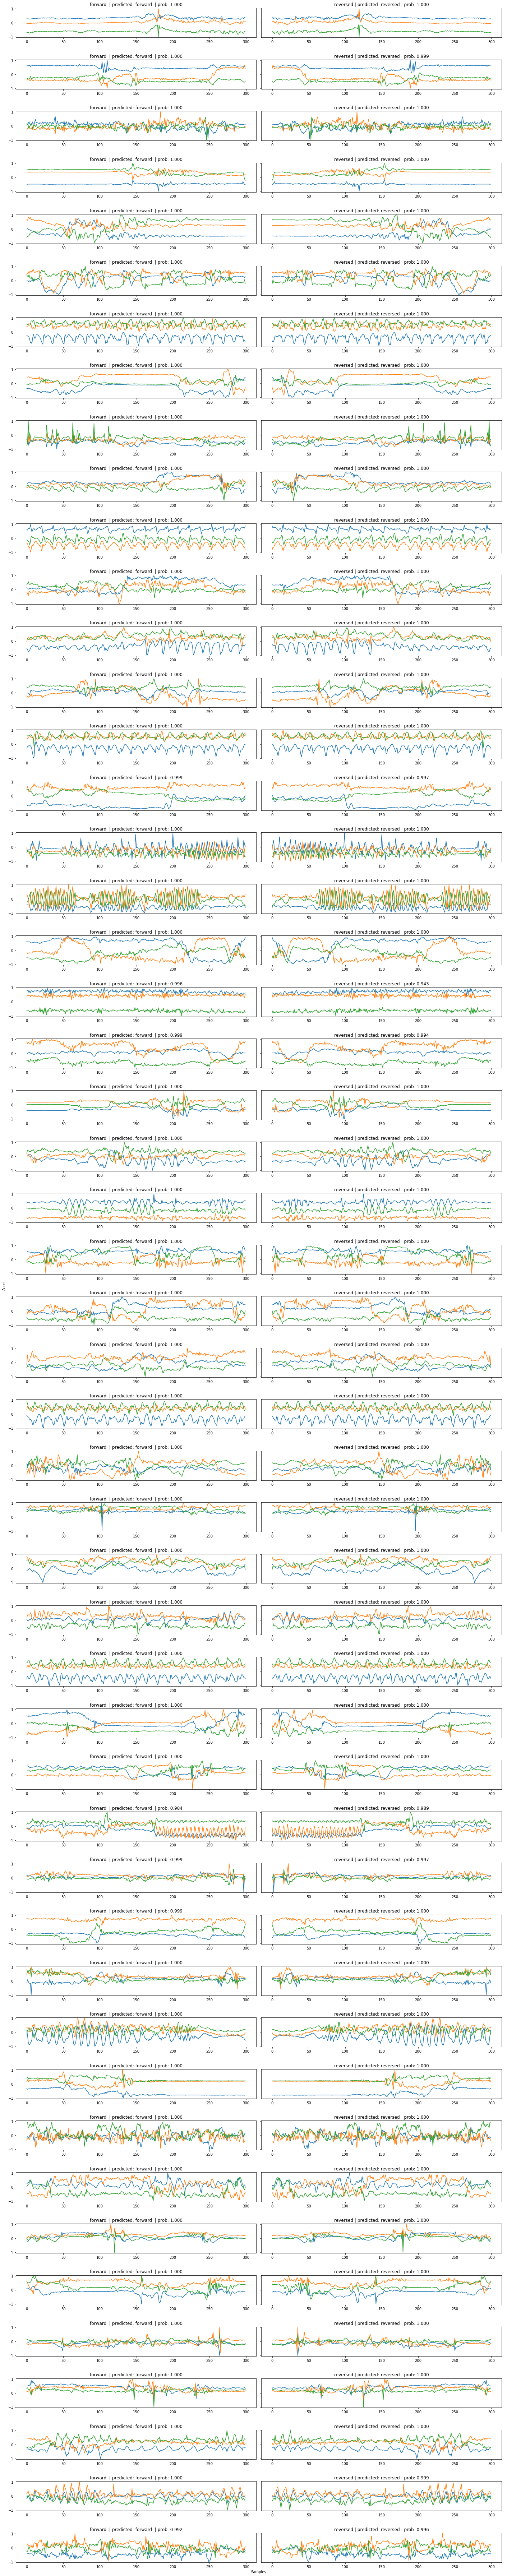

In [16]:
"""plot some random examples"""
sz=50
seed=42
rng = np.random.default_rng(seed) #56
randids = np.sort(rng.choice(len(indexs)-1, size=sz, replace=False))
randids=indexs[randids]

fig, axs = plt.subplots(sz, 2, figsize=(20, sz*2),
                        sharex=False, sharey=True);

fig.add_subplot(111, frameon=False)    
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Samples")
plt.ylabel('Accel')

for i in range(sz):
    idx=randids[i]    
    axs[i][0].plot(transform(X_fwd[idx]).T)
    axs[i][0].set_title('{:8s} | predicted: {:8s} | prob: {:.3f}'.format(labels[Y[fwd_idx][idx]], labels[Yfit[fwd_idx][idx]], np.max(prob[fwd_idx][idx]))) 
    axs[i][1].plot(transform(X_rev[idx]).T)
    axs[i][1].set_title('{:8s} | predicted: {:8s} | prob: {:.3f}'.format(labels[Y[rev_idx][idx]], labels[Yfit[rev_idx][idx]], np.max(prob[rev_idx][idx]))) 
    axs[i][0].set_ylim([-1.05, 1.05]);axs[i][1].set_ylim([-1.05, 1.05]);

plt.tight_layout()  
fig.subplots_adjust(hspace=0.75)
plt.show()

# LRP 

In [17]:

from captum.attr import LRP, InputXGradient
from interpretability import attribution as attr
from interpretability.attribution import Attribute
from interpretability.lrp_models import LRPEpsilonSSL,LRPCompositeSSL, _print_lrp_rules

#attribute the batch#

indexs_=randids
samp_sz=len(indexs_)

#-----------------------------------------------------------#
#                    LRP (fwd)
#-----------------------------------------------------------#

lrp=InputXGradient(model)
lrp = LRP(model)

#apply composite rule to the model
lrp_rule=LRPCompositeSSL(verbose=False)

model, _=lrp_rule(model)

#print the rules
_print_lrp_rules(model)

target=0 
analysis_model_param={'target': target}
analysis_model={'algorithm': lrp, 'parameters': analysis_model_param}
attribute_lrp_fwd=Attribute(model, lrp, **analysis_model_param)

R_fwd=attribute_lrp_fwd(torch.tensor(X_fwd[indexs_], requires_grad=True).to(device, dtype=torch.float))
R_fwd=R_fwd.squeeze().permute(0, 2, 1).cpu().detach().numpy() 

#-----------------------------------------------------------#
#                    LRP (rev)
#-----------------------------------------------------------#

lrp = LRP(model)

#apply composite rule to the model
lrp_rule=LRPCompositeSSL(verbose=False)
#lrp_rule=LRPEpsilonSSL(verbose=False, epsilon=100)

model, _=lrp_rule(model)

#print the rules
_print_lrp_rules(model)

target=1
analysis_model_param={'target': target}
analysis_model={'algorithm': lrp, 'parameters': analysis_model_param}
attribute_lrp_rev=Attribute(model, lrp, **analysis_model_param)

R_rev=attribute_lrp_rev(torch.tensor(X_rev[indexs_], requires_grad=True).to(device, dtype=torch.float))
R_rev=R_rev.squeeze().permute(0, 2, 1).cpu().detach().numpy() 


R_batch=np.vstack((R_fwd, R_rev))
print(R_batch.shape)

X_batch=np.vstack((X_fwd[indexs_], X_rev[indexs_]))
X_batch=np.transpose(X_batch, (0, 2, 1))


'''
#' Merge sample data#
#X_batch=np.vstack((X_fwd[indexs_],(X_rev[indexs_])))
#X_batch=torch.tensor(X_batch, requires_grad=True).to(device, dtype=torch.float)
#R_batch=attribute_lrp(X_batch)

#R_batch=R_batch.squeeze().permute(0, 2, 1).cpu().detach().numpy() 
#X_batch=X_batch.squeeze().permute(0, 2, 1).cpu().detach().numpy() 
'''

#perform relevance clipping manually
R_batch=[attr._relevance_clip(r, plim=98) for r in R_batch]
R_batch=np.asarray(R_batch)
#normalise attribution between [-1, 1]
R_batch=[attr._normalise_attribution(r) for r in R_batch]
R_batch=np.asarray(R_batch).squeeze()
 
## to convert back to fwd/rev relevance
#R_fwd=R_batch[:samp_sz]
#R_rev=R_batch[samp_sz:]


layer 60| rule: <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7ff6ffd7ac70> 
    structure: Linear(in_features=1024, out_features=2, bias=True)
----------------------------------------------------------------------------
layer 59| rule: <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7ff6ffd7aca0> 
    structure: Downsample()
----------------------------------------------------------------------------
layer 58| rule: default 
    structure: ReLU(inplace=True)
----------------------------------------------------------------------------
layer 57| rule: <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7ff6ffd7a670> 
    structure: BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
----------------------------------------------------------------------------
layer 56| rule: <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7ff6ffd7ac10> 
    structure: Conv1d(512, 1024, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mod

/home/scro3203/anaconda3/envs/ssl/lib/python3.9/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


layer 60| rule: <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7ff66b6a40d0> 
    structure: Linear(in_features=1024, out_features=2, bias=True)
----------------------------------------------------------------------------
layer 59| rule: <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7ff66b6a40a0> 
    structure: Downsample()
----------------------------------------------------------------------------
layer 58| rule: default 
    structure: ReLU(inplace=True)
----------------------------------------------------------------------------
layer 57| rule: <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7ff66b6a4130> 
    structure: BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
----------------------------------------------------------------------------
layer 56| rule: <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7ff66b6a4100> 
    structure: Conv1d(512, 1024, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mod

In [18]:
'''
from captum.attr import LRP, InputXGradient
from interpretability import attribution as attr
from interpretability.attribution import Attribute
from interpretability.lrp_models import LRPEpsilonSSL,LRPCompositeSSL, _print_lrp_rules

#attribute the batch#

indexs_=randids
samp_sz=len(indexs_)

#-----------------------------------------------------------#
#                    LRP (fwd)
#-----------------------------------------------------------#

ixg=InputXGradient(model)


target=0 
analysis_model_param={'target': target}
analysis_model={'algorithm': ixg, 'parameters': analysis_model_param}
attribute_lrp_fwd=Attribute(model, analysis_model['algorithm'], **analysis_model_param)

R_fwd=attribute_lrp_fwd(torch.tensor(X_fwd[indexs_], requires_grad=True).to(device, dtype=torch.float))
R_fwd=R_fwd.squeeze().permute(0, 2, 1).cpu().detach().numpy() 

#-----------------------------------------------------------#
#                    LRP (rev)
#-----------------------------------------------------------#



target=1
analysis_model_param={'target': target}
analysis_model={'algorithm': ixg, 'parameters': analysis_model_param}

attribute_lrp_rev=Attribute(model, analysis_model['algorithm'], **analysis_model_param)

R_rev=attribute_lrp_rev(torch.tensor(X_rev[indexs_], requires_grad=True).to(device, dtype=torch.float))
R_rev=R_rev.squeeze().permute(0, 2, 1).cpu().detach().numpy() 


R_batch=np.vstack((R_fwd, R_rev))
print(R_batch.shape)

X_batch=np.vstack((X_fwd[indexs_], X_rev[indexs_]))
X_batch=np.transpose(X_batch, (0, 2, 1))


'''
## Merge sample data#
#X_batch=np.vstack((X_fwd[indexs_],(X_rev[indexs_])))
#X_batch=torch.tensor(X_batch, requires_grad=True).to(device, dtype=torch.float)
#R_batch=attribute_lrp(X_batch)

#R_batch=R_batch.squeeze().permute(0, 2, 1).cpu().detach().numpy() 
#X_batch=X_batch.squeeze().permute(0, 2, 1).cpu().detach().numpy() 
'''

#perform relevance clipping manually
R_batch=[attr._relevance_clip(r, plim=98) for r in R_batch]
R_batch=np.asarray(R_batch)
#normalise attribution between [-1, 1]
R_batch=[attr._normalise_attribution(r) for r in R_batch]
R_batch=np.asarray(R_batch).squeeze()
 
## to convert back to fwd/rev relevance
#R_fwd=R_batch[:samp_sz]
#R_rev=R_batch[samp_sz:]
'''

'\n\n#perform relevance clipping manually\nR_batch=[attr._relevance_clip(r, plim=98) for r in R_batch]\nR_batch=np.asarray(R_batch)\n#normalise attribution between [-1, 1]\nR_batch=[attr._normalise_attribution(r) for r in R_batch]\nR_batch=np.asarray(R_batch).squeeze()\n \n## to convert back to fwd/rev relevance\n#R_fwd=R_batch[:samp_sz]\n#R_rev=R_batch[samp_sz:]\n'

## Run attribution

In [19]:
#easiest to declare these seperately
sidx=10

R_sample_fwd=R_batch[:samp_sz][sidx]
R_sample_rev=R_batch[samp_sz:][sidx]

X_sample_fwd=X_batch[:samp_sz][sidx]
X_sample_rev=X_batch[samp_sz:][sidx]

Y_sample_fwd=Y[fwd_idx][indexs_][sidx]
Y_sample_rev=Y[rev_idx][indexs_][sidx]

Yfit_sample_fwd=Yfit[fwd_idx][indexs_][sidx]
Yfit_sample_rev=Yfit[rev_idx][indexs_][sidx]

pr_sample_fwd=prob[fwd_idx][indexs_][sidx]
pr_sample_rev=prob[rev_idx][indexs_][sidx]

filename='LRP_sample_seed{:}_idx{:}_sidx{:}_sz{:}'.format(seed, indexs_[sidx], sidx, sz)


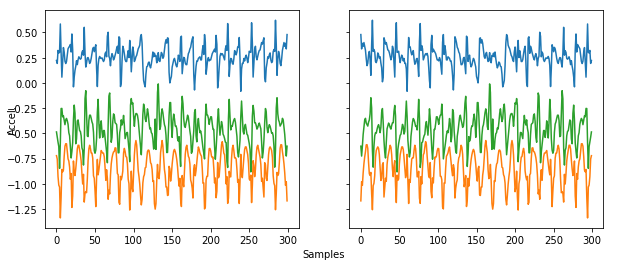

In [20]:
"""plot lrp distribution"""
fig, axs = plt.subplots(1, 2, figsize=(10, 4),
                        sharex=False, sharey=True);
fig.add_subplot(111, frameon=False)    
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Samples")
plt.ylabel('Accel.')

axs[0].plot(X_sample_fwd)
axs[1].plot(X_sample_rev)
plt.show()

# Plot LRP Example(s)

## Plotting Utilities 

In [21]:
from interpretability.attribution import plot_raw_accel, plot_cwt, plot_cwt_cbar, plot_pcolor_attribution
from interpretability.attribution import add_lrp_colorbar, plot_scatter_attribution
from interpretability.attribution import overlay_scatter_attribution, add_zoom_patch

## Set plotting parameters

In [22]:
import matplotlib
import matplotlib.axes
from mpl_toolkits.axes_grid1 import make_axes_locatable, Size
from mpl_toolkits.axes_grid1 import axes_size
import matplotlib.patches as patches
import matplotlib.ticker as ticker
from interpretability.attribution import tickLogFormat

lrp_limits=[-1, 1]
lrpmap=attr.create_lrp_colormap(limits=lrp_limits)
transform=Transform(transformations=['rescale'], channel_wise=False, limits=[-1, 1])

## normalise attribution between [-1, 1]
#R_sample=attr._normalise_attribution(R_sample)

#R_sample_fwd=attr._smooth_attribution(R_sample_fwd, window_size=3)
#R_sample_rev=attr._smooth_attribution(R_sample_rev, window_size=3)

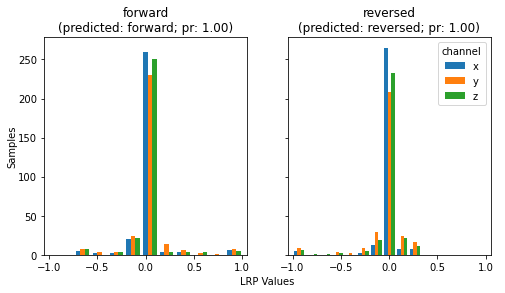

In [23]:
"""plot lrp distribution"""
fig, axs = plt.subplots(1, 2, figsize=(8, 4),
                        sharex=False, sharey=True);
fig.add_subplot(111, frameon=False)    
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel("Samples")
plt.xlabel('LRP Values')
#plt.title('Distribution of Attributions')

axs[0].hist(R_sample_fwd)
axs[0].set_xlim([-1.05, 1.05])
axs[0].set_title('{:}\n(predicted: {:}; pr: {:.2f})'.format(labels[Y_sample_fwd], labels[Yfit_sample_fwd], np.max(pr_sample_fwd)))
axs[1].hist(R_sample_rev)
axs[1].set_xlim([-1.05, 1.05])
axs[1].set_title('{:}\n(predicted: {:}; pr: {:.2f})'.format(labels[Y_sample_rev], labels[Yfit_sample_rev], np.max(pr_sample_rev)))
axs[1].legend(['x', 'y', 'z'], title='channel')

plt.show()

In [24]:
fs=30
sec=10 

nsamples, nchannel=X_sample_fwd.shape

xvalues = np.arange(nsamples)
time_stamps=(xvalues/fs)+1/fs
'''or'''
#time_stamps=np.linspace(1/fs, sec, fs*sec, endpoint=True)

#------------------------------------#
assert X_sample_fwd.shape==R_sample_fwd.shape
assert X_sample_rev.shape==R_sample_rev.shape
assert len(time_stamps)==len(xvalues)

In [25]:
"""Construct CWT"""
#rescale all signals between [0-1] so we can properly compare the amplitude of the CWT 
cwt_transform=Transform(transformations=['rescale'], channel_wise=False, limits=[0, 1])

Xmag_sample_fwd=np.linalg.norm(X_sample_fwd, axis=1)

cwt_vmax=1
cwt_abs_fwd, t_cwt, freq_cwt=attr.compute_cwt(Xmag_sample_fwd,time_stamps, fs, transformation=cwt_transform, pad_pc=1.5)

In [26]:
sec_start=0
sec_end=10
sec_gap=2

sec_length=sec_end-sec_start
#take only samples in time limit
time_mask=(time_stamps>=sec_start) & (time_stamps<sec_end+1/fs)

_X_sample_fwd = X_sample_fwd[time_mask]  
_R_sample_fwd = R_sample_fwd[time_mask] 
_time_stamps=time_stamps[time_mask]
_xvalues=xvalues[time_mask]

cwt_mask=(t_cwt>=sec_start) & (t_cwt<sec_end+1/fs)
_t_cwt=t_cwt[cwt_mask]
_freq_cwt=freq_cwt
_cwt_abs_fwd=cwt_abs_fwd[:, cwt_mask]

xticks=np.arange(sec_start, sec_end+1/fs, sec_gap)
#xticks_labels=["%.1f" % xt for xt in xticks]
xlim = xticks[[0,-1]]

cwt_vmax=1

parm={
    'nchannels': 3,
    'sec_start': sec_start,
    'sec_end': sec_end,
    'sec_gap': sec_gap,
    'ylim': [-1.05, 1.05],
    'cwt_yticks': [1, 3, 10, fs/2],
    'cwt_ylim': [0.5,fs/2],
    'cwt_vmax': cwt_vmax,
    'cwt_cbar_ticks': np.linspace(0,cwt_vmax,3),
    'cwt_cbar_limit': [0, cwt_vmax],
    'channel_labels': ['x', 'y', 'z'],
    'lrp_limits': [-1,1],
    'lrpmap': lrpmap,
    'xlim': xlim, 
    'xticks': xticks
}


## 1. Plot LRP (Forward)

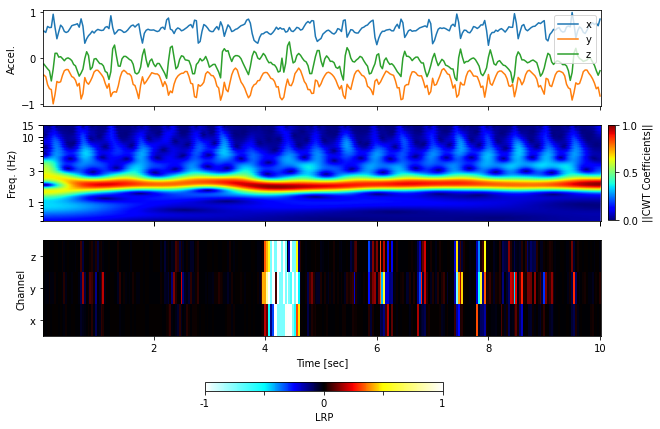

In [27]:
#0. set up figure
fig, axs = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=False,
                        sharex=True, sharey=False);
fig.add_subplot(111, frameon=False)    
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
#plt.title('label = {:10s} | predicted = {:10s} | prob={:.3f}'.format(actual, predicted, np.max(prob))) 

#1. Add raw accel. trace
plot_raw_accel(axs[0], transform(_X_sample_fwd), _time_stamps, **parm)

#2. Add time-frequency representation (using continous wavelet transform [CWT])
cwt_axis=plot_cwt(axs[1], _t_cwt, _freq_cwt, _cwt_abs_fwd, **parm)
plot_cwt_cbar(fig,cwt_axis[1], **parm)

#3. Add LRP (pseudocolor) relevance plot
plot_pcolor_attribution(axs[2],_R_sample_fwd, _time_stamps, **parm)
add_lrp_colorbar(fig, **parm)


plt.setp(axs[0], ylabel='Accel.')
plt.setp(axs[1], ylabel='Freq. (Hz)')
plt.setp(axs[2], ylabel='Channel')
plt.setp(axs[2], xlabel='Time [sec]')

plt.show()

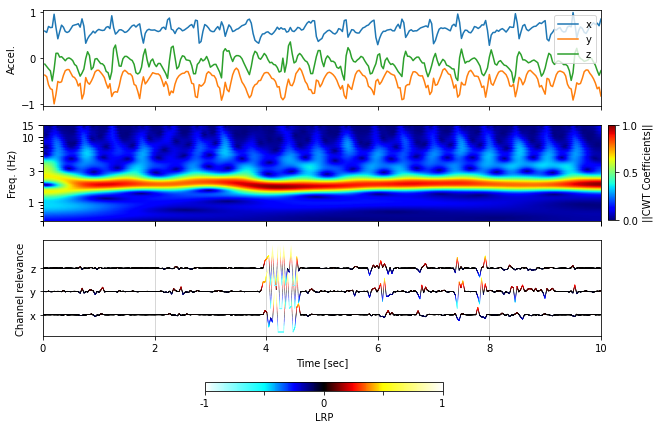

In [28]:
#0. set up figure
fig, axs = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=False,
                        sharex=True, sharey=False);
fig.add_subplot(111, frameon=False)    
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

#1. Add raw accel. trace
plot_raw_accel(axs[0], transform(_X_sample_fwd), _time_stamps, **parm)

#2. Add time-frequency representation (using continous wavelet transform [CWT])
cwt_axis=plot_cwt(axs[1], _t_cwt, _freq_cwt, _cwt_abs_fwd, **parm)
plot_cwt_cbar(fig, cwt_axis[1], **parm)

#3. Add LRP (magnitude attribition) relevance plot
plot_scatter_attribution(axs[2], _R_sample_fwd, _xvalues, **parm)
add_lrp_colorbar(fig, **parm)

plt.setp(axs[0], ylabel='Accel.')
plt.setp(axs[1], ylabel='Freq. (Hz)')
plt.setp(axs[2], ylabel='Channel relevance')
plt.setp(axs[-1], xlabel='Time [sec]')

plt.show()


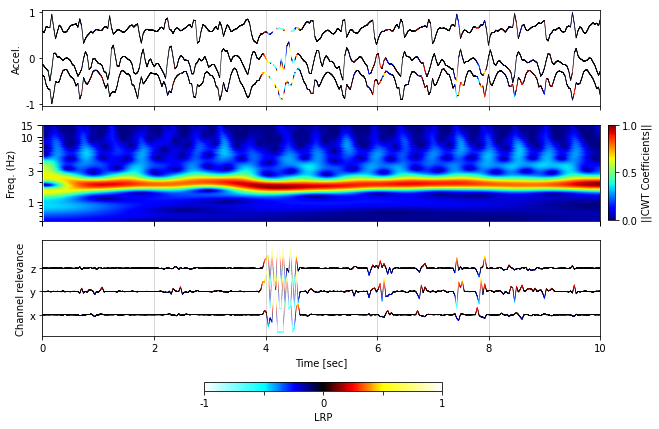

In [29]:
#0. set up figure
fig, axs = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=False,
                        sharex=True, sharey=False);
fig.add_subplot(111, frameon=False)    
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

#1. Overlay attribution directly to the signal
overlay_scatter_attribution(axs[0], _R_sample_fwd, transform(_X_sample_fwd), _xvalues, maxamp=1, **parm)

#2. Add time-frequency representation (using continous wavelet transform [CWT])
cwt_axis=plot_cwt(axs[1], _t_cwt, _freq_cwt, _cwt_abs_fwd, **parm)
plot_cwt_cbar(fig, cwt_axis[1], **parm)

#3. Add LRP (magnitude attribition) relevance plot
plot_scatter_attribution(axs[2], _R_sample_fwd, _xvalues, **parm)
add_lrp_colorbar(fig, **parm)

plt.setp(axs[0], ylabel='Accel.')
plt.setp(axs[1], ylabel='Freq. (Hz)')
plt.setp(axs[2], ylabel='Channel relevance')
plt.setp(axs[-1], xlabel='Time [sec]')

plt.show()

## 2. Plot LRP (Reversed)

In [30]:
"""Re-Construct the CWT"""
cwt_abs_rev, _, _=attr.compute_cwt(np.linalg.norm(X_sample_rev , axis=1),time_stamps, fs, transformation=cwt_transform, pad_pc=1.5)

_X_sample_rev = X_sample_rev[time_mask]  
_R_sample_rev = R_sample_rev[time_mask] 
_cwt_abs_rev=cwt_abs_rev[:, cwt_mask]


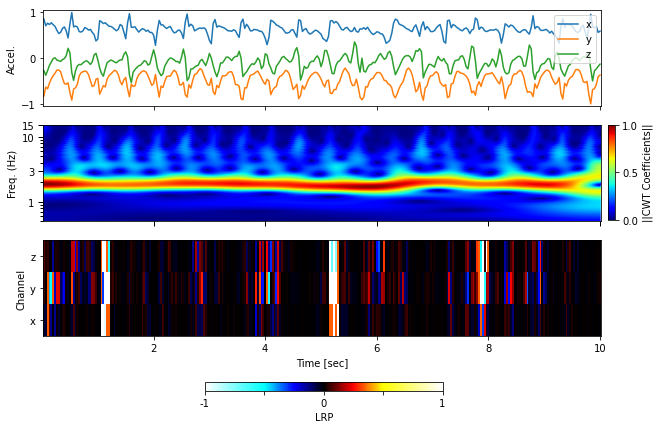

In [31]:
#0. set up figure
fig, axs = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=False,
                        sharex=True, sharey=False);
fig.add_subplot(111, frameon=False)    
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
#plt.title('label = {:10s} | predicted = {:10s} | prob={:.3f}'.format(actual, predicted, np.max(prob))) 

#1. Add raw accel. trace
plot_raw_accel(axs[0], transform(_X_sample_rev), _time_stamps, **parm)

#2. Add time-frequency representation (using continous wavelet transform [CWT])
cwt_axis=plot_cwt(axs[1], _t_cwt, _freq_cwt, _cwt_abs_rev, **parm)
plot_cwt_cbar(fig,cwt_axis[1], **parm)

#3. Add LRP (pseudocolor) relevance plot
plot_pcolor_attribution(axs[2], _R_sample_rev, _time_stamps, **parm)
add_lrp_colorbar(fig, **parm)


plt.setp(axs[0], ylabel='Accel.')
plt.setp(axs[1], ylabel='Freq. (Hz)')
plt.setp(axs[2], ylabel='Channel')
plt.setp(axs[2], xlabel='Time [sec]')

plt.show()

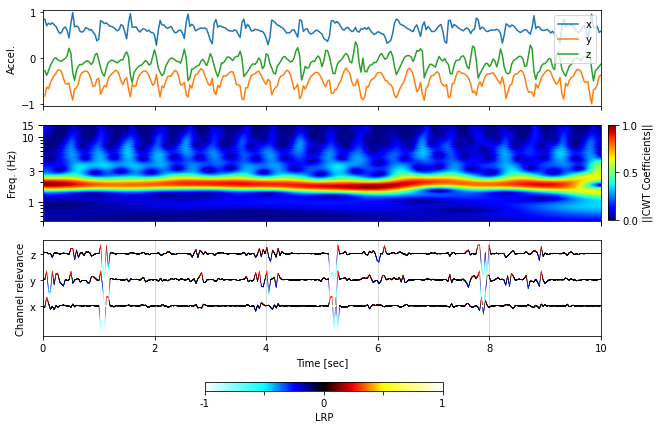

In [32]:
#0. set up figure
fig, axs = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=False,
                        sharex=True, sharey=False);
fig.add_subplot(111, frameon=False)    
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

#1. Add raw accel. trace
plot_raw_accel(axs[0], transform(_X_sample_rev), _time_stamps, **parm)

#2. Add time-frequency representation (using continous wavelet transform [CWT])
cwt_axis=plot_cwt(axs[1], _t_cwt, _freq_cwt, _cwt_abs_rev, **parm)
plot_cwt_cbar(fig, cwt_axis[1], **parm)

#3. Add LRP (magnitude attribition) relevance plot
plot_scatter_attribution(axs[2], _R_sample_rev, _xvalues, **parm)
add_lrp_colorbar(fig, **parm)

plt.setp(axs[0], ylabel='Accel.')
plt.setp(axs[1], ylabel='Freq. (Hz)')
plt.setp(axs[2], ylabel='Channel relevance')
plt.setp(axs[-1], xlabel='Time [sec]')

plt.show()


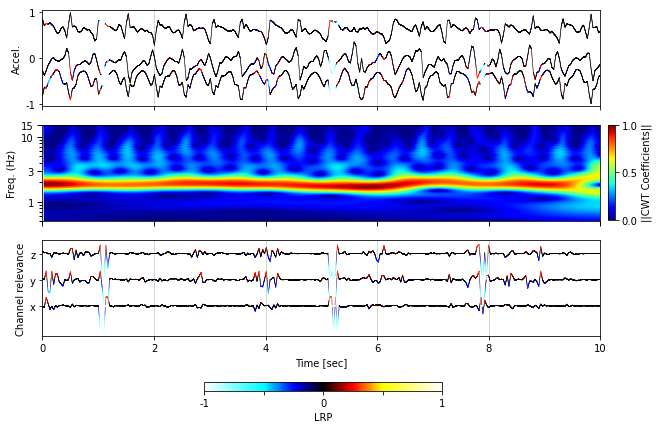

In [33]:
#0. set up figure
fig, axs = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=False,
                        sharex=True, sharey=False);
fig.add_subplot(111, frameon=False)    
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

#1. Overlay attribution directly to the signal
overlay_scatter_attribution(axs[0], _R_sample_rev, transform(_X_sample_rev), _xvalues, maxamp=1, **parm)

#2. Add time-frequency representation (using continous wavelet transform [CWT])
cwt_axis=plot_cwt(axs[1], _t_cwt, _freq_cwt, _cwt_abs_rev, **parm)
plot_cwt_cbar(fig, cwt_axis[1], **parm)

#3. Add LRP (magnitude attribition) relevance plot
plot_scatter_attribution(axs[2], _R_sample_rev, _xvalues, **parm)
add_lrp_colorbar(fig, **parm)

plt.setp(axs[0], ylabel='Accel.')
plt.setp(axs[1], ylabel='Freq. (Hz)')
plt.setp(axs[2], ylabel='Channel relevance')
plt.setp(axs[-1], xlabel='Time [sec]')

plt.show()

<ipython-input-34-4e7cae61f8be>:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


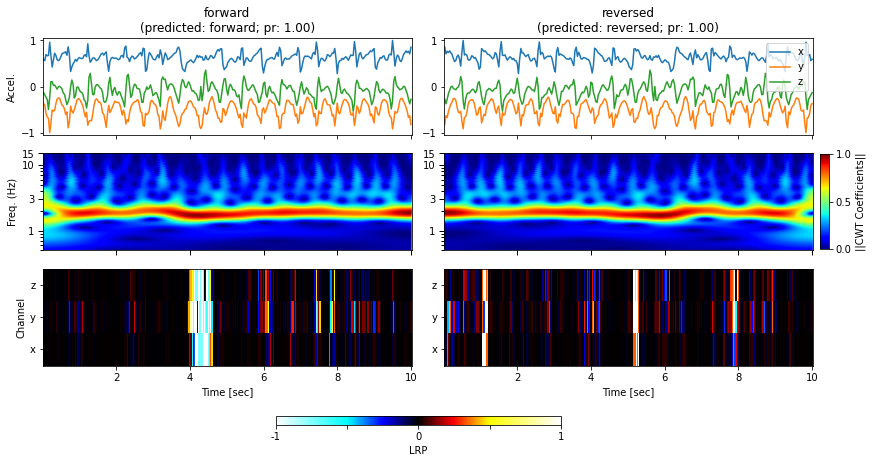

In [34]:
#0. set up figure
fig, axs = plt.subplots(3, 2, figsize=(12, 6), constrained_layout=False,
                        sharex=True, sharey=False);
fig.add_subplot(111, frameon=False)    
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

#1. Add raw accel. trace
plot_raw_accel(axs[0][0], transform(_X_sample_fwd), _time_stamps, **parm)
plot_raw_accel(axs[0][1], transform(_X_sample_rev), _time_stamps, **parm)

#2. Add time-frequency representation (using continous wavelet transform [CWT])
cwt_axis=plot_cwt(axs[1][0], _t_cwt, _freq_cwt, _cwt_abs_fwd, **parm)
cwt_axis=plot_cwt(axs[1][1], _t_cwt, _freq_cwt, _cwt_abs_rev, **parm)
plot_cwt_cbar(fig,cwt_axis[1],axis=[0.98, 0.405, 0.01, 0.22], **parm)

#3. Add LRP (pseudocolor) relevance plot
plot_pcolor_attribution(axs[2][0], _R_sample_fwd, _time_stamps, **parm)
plot_pcolor_attribution(axs[2][1], _R_sample_rev, _time_stamps, **parm)
add_lrp_colorbar(fig, **parm)


plt.setp(axs[0][0], ylabel='Accel.')
plt.setp(axs[1][0], ylabel='Freq. (Hz)')
plt.setp(axs[2][0], ylabel='Channel')
plt.setp(axs[2], xlabel='Time [sec]')

plt.setp(axs[0][0], title='{:}\n(predicted: {:}; pr: {:.2f})'.format(labels[Y_sample_fwd], labels[Yfit_sample_fwd], np.max(pr_sample_fwd)))
plt.setp(axs[0][1], title='{:}\n(predicted: {:}; pr: {:.2f})'.format(labels[Y_sample_rev], labels[Yfit_sample_rev], np.max(pr_sample_rev)))

plt.tight_layout()

# Save files in pdf and eps format
#plt.savefig(SAVE_PATH + 'SBS_pcolor_' + filename +  ".pdf", dpi=150, facecolor='w', bbox_inches='tight')
#plt.savefig(SAVE_PATH + 'SBS_pcolor_' + filename +  ".svg", facecolor='w', bbox_inches='tight')
#plt.savefig(SAVE_PATH + 'SBS_pcolor_' + filename +  ".png",  dpi=300, facecolor='w', bbox_inches='tight')

plt.show()

<ipython-input-35-9792ef29852d>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


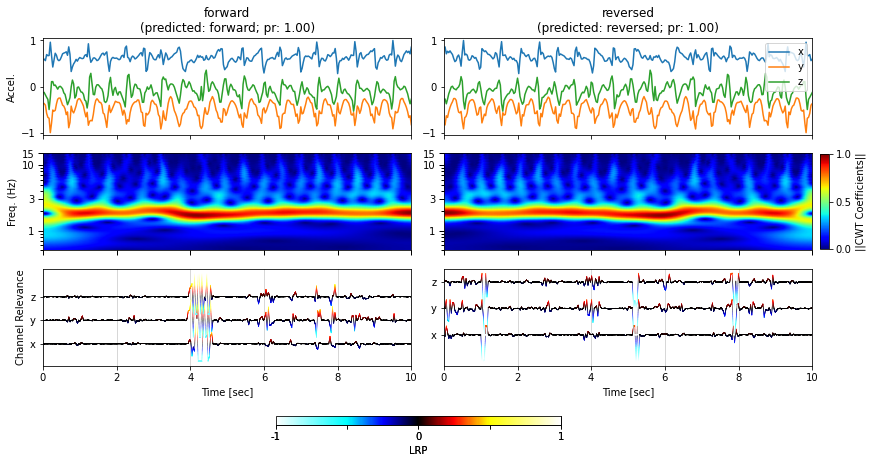

In [35]:
#0. set up figure
fig, axs = plt.subplots(3, 2, figsize=(12, 6), constrained_layout=False,
                        sharex=True, sharey=False);
fig.add_subplot(111, frameon=False)    
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

#1. Add raw accel. trace
plot_raw_accel(axs[0][0], transform(_X_sample_fwd), _time_stamps, **parm)
plot_raw_accel(axs[0][1], transform(_X_sample_rev), _time_stamps, **parm)

#2. Add time-frequency representation (using continous wavelet transform [CWT])
cwt_axis=plot_cwt(axs[1][0], _t_cwt, _freq_cwt, _cwt_abs_fwd, **parm)
cwt_axis=plot_cwt(axs[1][1], _t_cwt, _freq_cwt, _cwt_abs_rev, **parm)
hdl_cbar_cwt=plot_cwt_cbar(fig,cwt_axis[1], axis=[0.98, 0.405, 0.01, 0.22], **parm)

#3. Add LRP (magnitude attribition) relevance plot
#plot_pcolor_attribution(axs[2][0], _R_sample_fwd, _time_stamps, **parm)
#plot_pcolor_attribution(axs[2][1], _R_sample_rev, _time_stamps, **parm)

plot_scatter_attribution(axs[2][0], _R_sample_fwd, _xvalues, **parm)
plot_scatter_attribution(axs[2][1], _R_sample_rev, _xvalues, **parm)
add_lrp_colorbar(fig, **parm)

hdl_cbar_lrp=add_lrp_colorbar(fig, **parm)


plt.setp(axs[0][0], ylabel='Accel.')
plt.setp(axs[1][0], ylabel='Freq. (Hz)')
plt.setp(axs[2][0], ylabel='Channel Relevance')
plt.setp(axs[2], xlabel='Time [sec]')

plt.setp(axs[0][0], title='{:}\n(predicted: {:}; pr: {:.2f})'.format(labels[Y_sample_fwd], labels[Yfit_sample_fwd], np.max(pr_sample_fwd)))
plt.setp(axs[0][1], title='{:}\n(predicted: {:}; pr: {:.2f})'.format(labels[Y_sample_rev], labels[Yfit_sample_rev], np.max(pr_sample_rev)))

plt.tight_layout()

# Save files in pdf and eps format
plt.savefig(SAVE_PATH + 'SBS_ocolor_' + filename +  ".pdf", dpi=150,  bbox_inches='tight')
#plt.savefig(SAVE_PATH + 'SBS_ocolor_' + filename +  ".svg", bbox_inches='tight')
plt.savefig(SAVE_PATH + 'SBS_ocolor_' + filename +  ".png", dpi=300, bbox_inches='tight')

plt.show()

<ipython-input-36-9792ef29852d>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


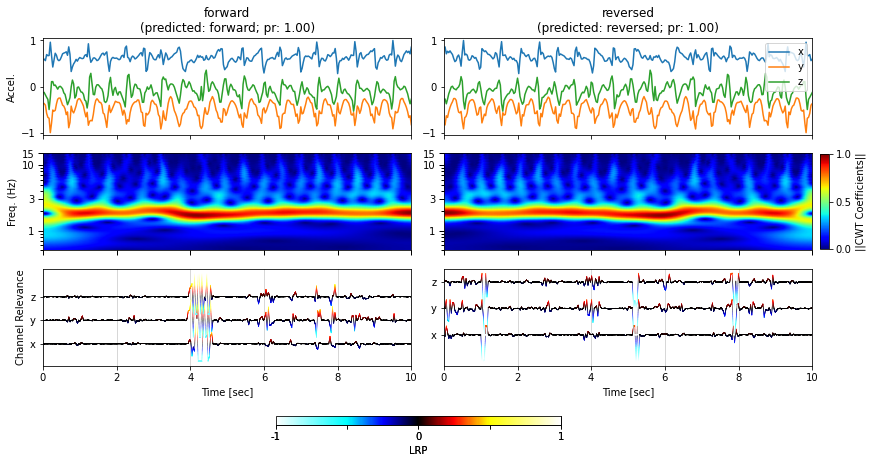

In [36]:
#0. set up figure
fig, axs = plt.subplots(3, 2, figsize=(12, 6), constrained_layout=False,
                        sharex=True, sharey=False);
fig.add_subplot(111, frameon=False)    
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

#1. Add raw accel. trace
plot_raw_accel(axs[0][0], transform(_X_sample_fwd), _time_stamps, **parm)
plot_raw_accel(axs[0][1], transform(_X_sample_rev), _time_stamps, **parm)

#2. Add time-frequency representation (using continous wavelet transform [CWT])
cwt_axis=plot_cwt(axs[1][0], _t_cwt, _freq_cwt, _cwt_abs_fwd, **parm)
cwt_axis=plot_cwt(axs[1][1], _t_cwt, _freq_cwt, _cwt_abs_rev, **parm)
hdl_cbar_cwt=plot_cwt_cbar(fig,cwt_axis[1], axis=[0.98, 0.405, 0.01, 0.22], **parm)

#3. Add LRP (magnitude attribition) relevance plot
#plot_pcolor_attribution(axs[2][0], _R_sample_fwd, _time_stamps, **parm)
#plot_pcolor_attribution(axs[2][1], _R_sample_rev, _time_stamps, **parm)

plot_scatter_attribution(axs[2][0], _R_sample_fwd, _xvalues, **parm)
plot_scatter_attribution(axs[2][1], _R_sample_rev, _xvalues, **parm)
add_lrp_colorbar(fig, **parm)

hdl_cbar_lrp=add_lrp_colorbar(fig, **parm)


plt.setp(axs[0][0], ylabel='Accel.')
plt.setp(axs[1][0], ylabel='Freq. (Hz)')
plt.setp(axs[2][0], ylabel='Channel Relevance')
plt.setp(axs[2], xlabel='Time [sec]')

plt.setp(axs[0][0], title='{:}\n(predicted: {:}; pr: {:.2f})'.format(labels[Y_sample_fwd], labels[Yfit_sample_fwd], np.max(pr_sample_fwd)))
plt.setp(axs[0][1], title='{:}\n(predicted: {:}; pr: {:.2f})'.format(labels[Y_sample_rev], labels[Yfit_sample_rev], np.max(pr_sample_rev)))

plt.tight_layout()

# Save files in pdf and eps format
plt.savefig(SAVE_PATH + 'SBS_ocolor_' + filename +  ".pdf", dpi=150,  bbox_inches='tight')
#plt.savefig(SAVE_PATH + 'SBS_ocolor_' + filename +  ".svg", bbox_inches='tight')
plt.savefig(SAVE_PATH + 'SBS_ocolor_' + filename +  ".png", dpi=300, bbox_inches='tight')

plt.show()

## to-do
- pick the interesting plots
- look at false negative and false positive examples